In [1]:
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
import cifar10
import dnn
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import seaborn as sns

#### Convert neural network to graph

In [2]:
N = 1000
num_runs = 3
rand_inds = cifar10.subsample_test(N)
def get_activation_networks(inputs, run=1, num_layers=4, num_epochs=10):
    from tensorflow.keras.layers import Dense
    model = dnn.load_run(run+1, dataset='cifar10', num_layers=num_layers, num_epochs=num_epochs)
    layer_sizes = [inputs.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
    _, g_xs = nn2graph.dense_activations_to_graph(model, inputs)
    return g_xs, layer_sizes

def get_layer_sizes(inputs, num_layers=4, num_outputs=10, hidden_dims=64):
    layer_sizes = [inputs[0].shape[-1]]
    for i in range(num_layers):
        layer_sizes.append(hidden_dims)
    layer_sizes.append(num_outputs)
    return layer_sizes

#### Mean weighted degree distributions per class

In [3]:
def compute_mean_weighted_degrees(inputs):
    mean_weighted_degrees = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(inputs, run=i)
        mean_weighted_degrees.append([float(g.vp['degree'].a[inputs.shape[-1]:].mean()) for g in g_xs])
        del g_xs
    mean_weighted_degrees = np.array(mean_weighted_degrees).mean(axis=0)
    return mean_weighted_degrees
    
def compute_mean_weighted_degrees_by_layer(inputs):
    mean_weighted_degrees_by_layer = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(inputs, run=i)
        layer_mean_degrees = []
        for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
            mean_weighted_degrees = [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]
            layer_mean_degrees.append(mean_weighted_degrees)
        mean_weighted_degrees_by_layer.append(np.array(layer_mean_degrees))
        del g_xs
    mean_weighted_degrees_by_layer = np.array(mean_weighted_degrees_by_layer).mean(axis=0)
    return mean_weighted_degrees_by_layer

In [4]:
mean_weighted_degrees = compute_mean_weighted_degrees(cifar10.X_test[rand_inds])
mean_weighted_degrees_by_layer = compute_mean_weighted_degrees_by_layer(cifar10.X_test[rand_inds])

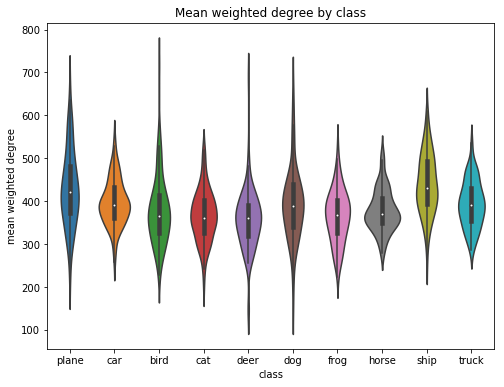

In [5]:
g_xs_mean_degree_by_class = pd.DataFrame({'class': cifar10.test_labels[rand_inds],
                                          'mean weighted degree': mean_weighted_degrees})
plt.figure(figsize=(8,6))
sns.violinplot(x='class', y='mean weighted degree', data=g_xs_mean_degree_by_class)
plt.title('Mean weighted degree by class')
plt.show()

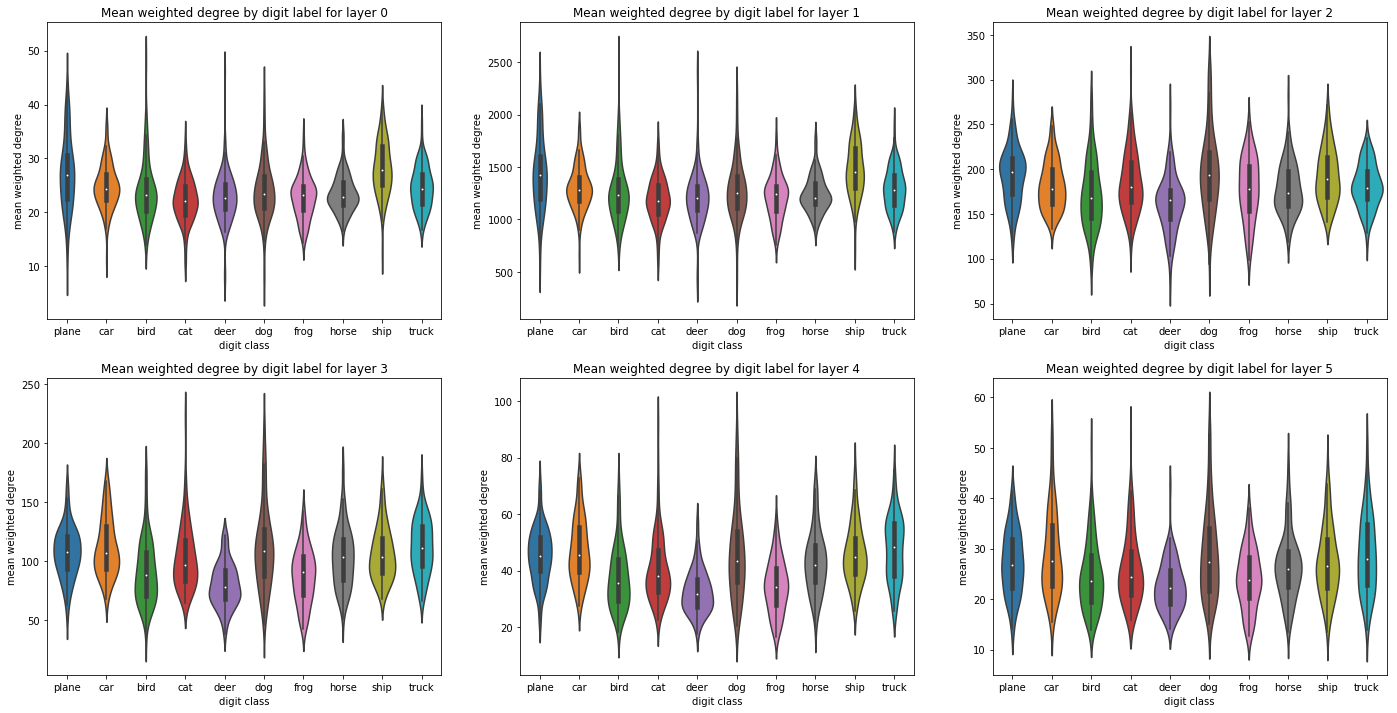

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for i in range(6):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_by_class_ = pd.DataFrame({'digit class': cifar10.test_labels[rand_inds].flatten(),
                                               'mean weighted degree': mean_weighted_degrees_by_layer[i]})
    sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class_,
                   ax=ax)
    ax.set_title('Mean weighted degree by digit label for layer {}'.format(i))
plt.show()

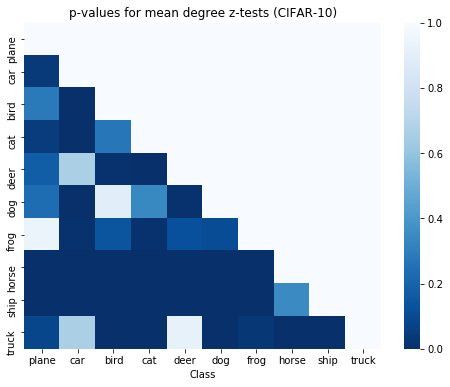

In [18]:
from statsmodels.stats.weightstats import ztest

groups_by_class = g_xs_mean_degree_by_class.groupby('class').groups.items()
p_vals = np.ones((10,10))
for i, (c_1, inds_1) in enumerate(groups_by_class):
    for j, (c_2, inds_2) in enumerate(groups_by_class):
        if j >= i:
            continue
        sample_1 = g_xs_mean_degree_by_class.loc[inds_1, 'mean weighted degree']
        sample_2 = g_xs_mean_degree_by_class.loc[inds_2, 'mean weighted degree']
        z, p = ztest(sample_1, sample_2)
        p_vals[i, j] = p
plt.figure(figsize=(8,6))
sns.heatmap(p_vals, cmap='Blues_r', xticklabels=cifar10.labels, yticklabels=cifar10.labels)
plt.title('p-values for mean degree z-tests (CIFAR-10)')
plt.xlabel('Class')
plt.show()

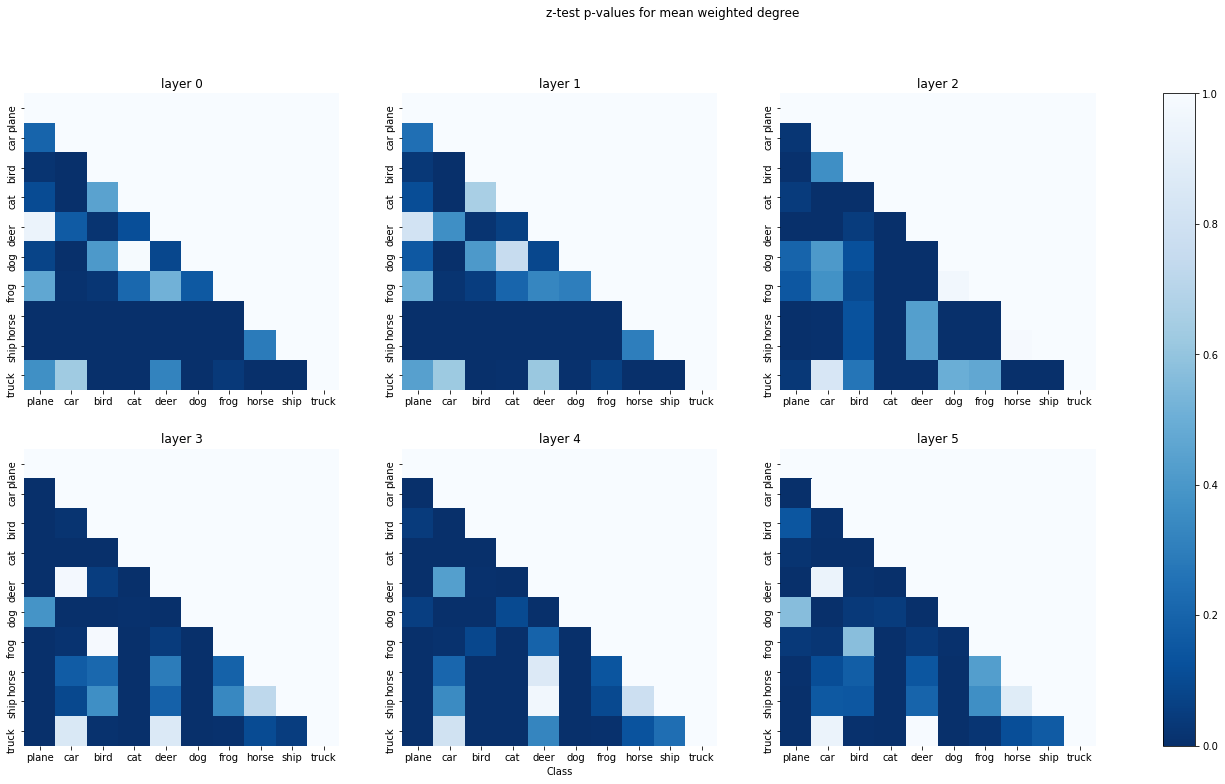

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for k in range(6):
    ax = axs[0 if k < 3 else 1, k%3]
    g_xs_mean_degree_by_class_l = pd.DataFrame({'class': cifar10.test_labels[rand_inds].flatten(),
                                                'mean weighted degree': mean_weighted_degrees_by_layer[k]})
    groups_by_class = g_xs_mean_degree_by_class_l.groupby('class').groups.items()
    p_vals = np.ones((10,10))
    for i, (c_1, inds_1) in enumerate(groups_by_class):
        for j, (c_2, inds_2) in enumerate(groups_by_class):
            if j >= i:
                continue
            sample_1 = g_xs_mean_degree_by_class_l.loc[inds_1, 'mean weighted degree']
            sample_2 = g_xs_mean_degree_by_class_l.loc[inds_2, 'mean weighted degree']
            z, p = ztest(sample_1, sample_2)
            p_vals[i, j] = p
    hmap = sns.heatmap(p_vals, cmap='Blues_r', ax=ax, cbar=False, xticklabels=cifar10.labels, yticklabels=cifar10.labels)
    ax.set_title('layer {}'.format(k))
    if k == 4:
        ax.set_xlabel('Class')
plt.colorbar(hmap.get_children()[0], ax=axs)
plt.suptitle('z-test p-values for mean weighted degree')
plt.show()

#### Mean weighted degrees vs number of active inputs

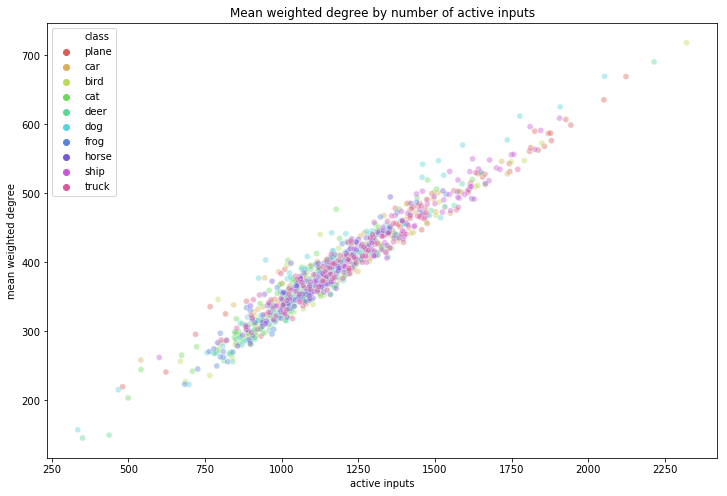

In [9]:
g_xs_degree_by_inputs = pd.DataFrame({'active inputs': np.sum(cifar10.X_test[rand_inds], axis=1),
                                      'class': cifar10.test_labels[rand_inds].flatten(),
                                      'mean weighted degree': mean_weighted_degrees})
plt.figure(figsize=(12,8))
sns.scatterplot(x='active inputs', y='mean weighted degree', hue='class',
                palette=sns.color_palette('hls', 10), alpha=0.4,
                data=g_xs_degree_by_inputs)
plt.title('Mean weighted degree by number of active inputs')
plt.show()

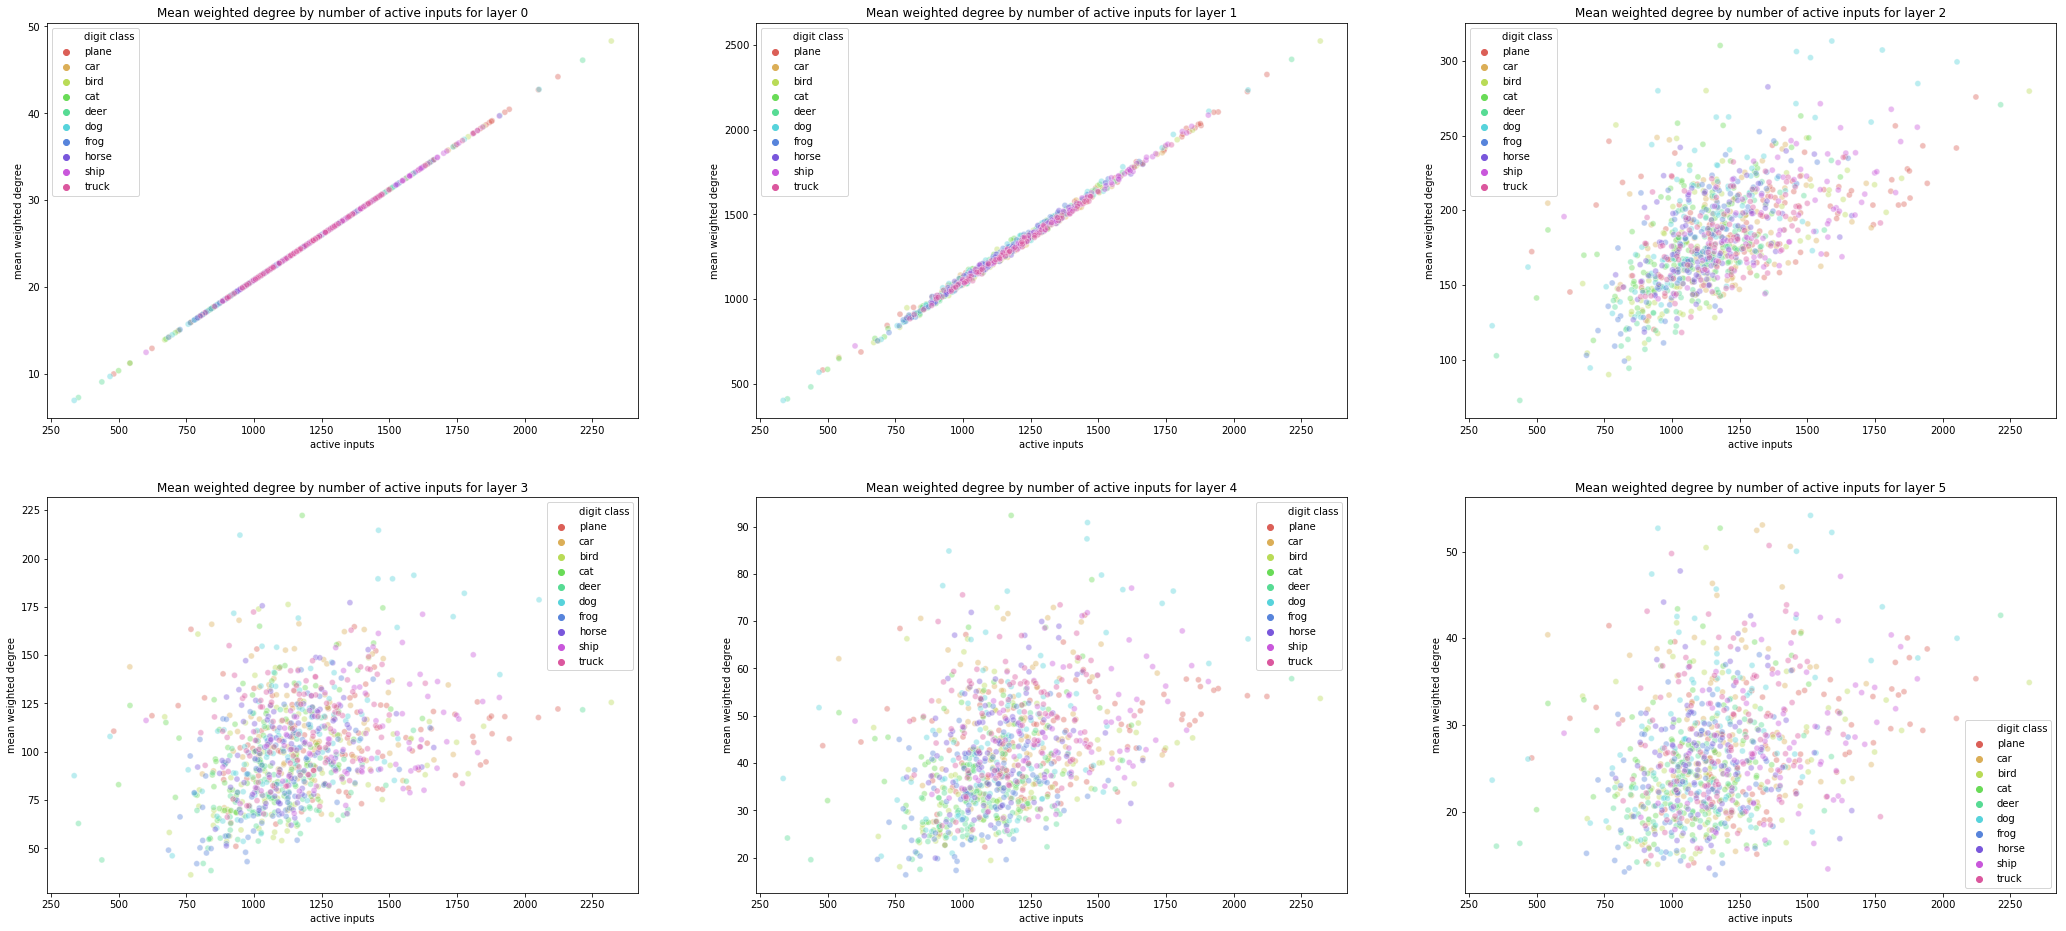

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(3*12,2*8))
for i in range(6):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_vs_inputs = pd.DataFrame({'active inputs': np.sum(cifar10.X_test[rand_inds], axis=1),
                                               'digit class': cifar10.test_labels[rand_inds].flatten(),
                                               'mean weighted degree': mean_weighted_degrees_by_layer[i]})
    sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                    palette=sns.color_palette('hls', 10), alpha=0.4,
                    data=g_xs_mean_degree_vs_inputs,
                    ax=ax)
    ax.set_title('Mean weighted degree by number of active inputs for layer {}'.format(i))
plt.show()

In [11]:
from scipy.spatial.distance import pdist, squareform
def deg_pdf(g):
    degs = g.vp['degree'].a
    pdf = degs / np.sum(degs)
    return pdf
N = 1000
g_xs, _ = get_activation_networks(cifar10.X_test[rand_inds], run=1, num_layers=4, num_epochs=10)
sub_inds = np.concatenate([np.random.choice(np.where(cifar10.test_label_ids[rand_inds] == c)[0], N // 10, replace=False) for c in range(10)], axis=0)
labels, pdfs = zip(*[(cifar10.test_label_ids[rand_inds[i]], deg_pdf(g_xs[i])) for i in sub_inds])
labels, pdfs = np.array(labels), np.array(pdfs)
js_dists = squareform(pdist(pdfs, metric='jensenshannon'))
avg_dists = np.ones((10,10))
for i in range(10):
    for j in range(10):
        avg_dists[i,j] = np.mean(js_dists[i*100:(i+1)*100,j*100:(j+1)*100])
del g_xs

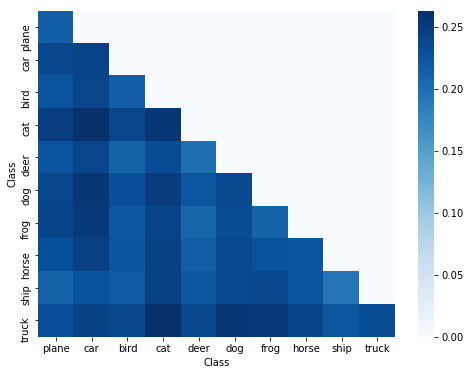

In [17]:
plt.figure(figsize=(8,6))
sns.heatmap(avg_dists*np.tril(np.ones((10,10))), xticklabels=cifar10.labels, yticklabels=cifar10.labels, cmap='Blues')
#plt.title('Average Jensen-Shannon distance between degree distributions (CIFAR-10)')
plt.xlabel('Class')
plt.ylabel('Class')
plt.show()